# 1. Introdução
Indicador usado: RSI
Vamos comprar a ação sempre que o RSI for menor do que 30. 

## 1.1. Passos
* Escolher um ativo. 
* Puxar os dados de cotações do Yahoo Finance
* Calcular os retornos positivos e negativos
* Separar os retornor positivos e negativos
* Calcular a media dos retornos positivos e negativos dos ultimos 10 dias. 
* Calcular o RSI
* Gerar os sinais de compra e venda
* Observando pontos de compra e venda ao longo do tempo
* Calculando lucros
* Analisando lucros 

    * Qual a média de lucros?
    * Qual a média de perdas?
    * Qual a % de operações vencedoras?
    * Qual a expectativa matemática do modelo?
    * Qual o retorno acumulado? 
    * O retorno venceu o buy and hold da ação? 

* Formula do RSI 
100 - 100(1 + mediaRetornosPositivos/mediaRetornosNegativos)

In [85]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import yfinance as yf
import seaborn as sb
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot
import plotly.graph_objs as go
import plotly.offline as pyo

# 2. Escolhendo ativo e Obtendo dados

In [86]:
def get_data(ticker, start_date, end_date, plot_data_price, plot_data_price_and_momento, plot_autocorrelations):
    yf.pdr_override()
    data = web.get_data_yahoo(ticker, start=start_date, end=end_date)
    data = pd.DataFrame(data)
    data = data_treatment(data)
    
    #Plots 
    if plot_data_price:
        plot_data(data, ticker)
    
    if plot_data_price_and_momento:
        plot_all_data(data, ticker)
    
    if plot_autocorrelations:
        plot_auto_correlation(data, ticker)    
    return data
     
def plot_data(dataset, ticker):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=dataset.index, y=dataset['Adj Close'], mode='lines', name='Adjusted Close'))
    fig.update_layout(
        title=f'Adjusted Close Price {ticker}',
        xaxis_title='Date',
        yaxis_title='Adjusted Close Price',
        template='plotly_dark',  
        width=1200,  
        height=500   
    )
    fig.show()

def plot_all_data(dataset, ticker):
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True,
                    subplot_titles=('Adjusted Close', 'Adj Close Momentum', 'Adj Close Momentum Acceleration'),
                    vertical_spacing=0.1)


    fig.add_trace(go.Scatter(x=dataset.index, y=dataset['Adj Close'],
                            mode='lines', name='Adjusted Close'),
                row=1, col=1)


    fig.add_trace(go.Scatter(x=dataset.index, y=dataset['Adj_Close_Momentum'],
                            mode='lines', name='Adjusted Close Momentum'),
                row=2, col=1)


    fig.add_trace(go.Scatter(x=dataset.index, y=dataset['Adj_Close_Momentum_Acceleration'],
                            mode='lines', name='Adjusted Close Momentum Acceleration'),
                row=3, col=1)


    fig.update_layout(
        title=f'Adjusted Close and Its Differences {ticker}',
        xaxis_title='Date',
        yaxis_title='Value',
        template='plotly_dark',
        height=800,  
        showlegend=False 
    )
    fig.show()

def plot_auto_correlation(dataset, ticker):
    ax = plt.figure(figsize=(20,4))
    ax.suptitle(f"Autocorrelation {ticker}")
    ax = autocorrelation_plot(dataset['Adj Close'])
    ax.grid(True, linestyle='-', alpha=0.8)
    
    ax = plt.figure(figsize=(20,4))
    ax.suptitle(f"Autocorrelation {ticker}")
    ax = autocorrelation_plot(dataset['Adj_Close_Momentum'])
    ax.grid(True, linestyle='-', alpha=0.8)

    ax = plt.figure(figsize=(20,4))
    ax.suptitle(f"Autocorrelation {ticker}")
    ax = autocorrelation_plot(dataset['Adj_Close_Momentum_Acceleration'])
    ax.grid(True, linestyle='-', alpha=0.8)

def data_treatment(dataset):
    dataset['Adj_Close_Momentum'] = dataset['Adj Close'].diff() 
    dataset['Adj_Close_Momentum_Acceleration'] = dataset['Adj_Close_Momentum'].diff()
    dataset = dataset.dropna()
    return dataset


In [87]:
tickers = ["ITSA4.SA"]
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data = get_data(tickers[0], start_date=start_date, end_date=end_date, plot_data_price=True, plot_data_price_and_momento=False, plot_autocorrelations=False)

[*********************100%%**********************]  1 of 1 completed


In [88]:
data = data.drop(['Adj_Close_Momentum', 'Adj_Close_Momentum_Acceleration'], axis=1)
data = data.round(2)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-06,11.59,11.67,11.50,11.59,8.87,24689820
2020-01-07,11.59,11.61,11.35,11.43,8.75,24441738
2020-01-08,11.45,11.54,11.23,11.26,8.62,23608953
2020-01-09,11.28,11.31,11.02,11.04,8.45,31727579
2020-01-10,11.08,11.22,10.90,10.96,8.40,30528333


# 3. Calculando Retornos 

In [89]:
data['returns'] = data['Adj Close'].pct_change().dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2020-01-06,11.59,11.67,11.50,11.59,8.87,24689820,NaN
2020-01-07,11.59,11.61,11.35,11.43,8.75,24441738,-0.013529
2020-01-08,11.45,11.54,11.23,11.26,8.62,23608953,-0.014857
2020-01-09,11.28,11.31,11.02,11.04,8.45,31727579,-0.019722
2020-01-10,11.08,11.22,10.90,10.96,8.40,30528333,-0.005917


# 4. Separando retornos positivos e negativos

In [90]:
data['positive_return'] = data.returns.apply(lambda x: x if x>0 else 0)
data['negative_return'] = data.returns.apply(lambda x: abs(x) if x<0 else 0)
data.head()

,Open,High,Low,Close,Adj Close,Volume,returns,positive_return,negative_return
Date,,,,,,,,,
2020-01-06,11.59,11.67,11.50,11.59,8.87,24689820,NaN,0.0,0.000000
2020-01-07,11.59,11.61,11.35,11.43,8.75,24441738,-0.013529,0.0,0.013529
2020-01-08,11.45,11.54,11.23,11.26,8.62,23608953,-0.014857,0.0,0.014857
2020-01-09,11.28,11.31,11.02,11.04,8.45,31727579,-0.019722,0.0,0.019722
2020-01-10,11.08,11.22,10.90,10.96,8.40,30528333,-0.005917,0.0,0.005917


# 5. Média dos retornos positivos e negativos dos ultimos 22 dias.

In [91]:
data['avg_positive_return'] = data['positive_return'].rolling(window=22).mean()
data['avg_negative_return'] = data['negative_return'].rolling(window=22).mean()

# 6. RSI 

In [92]:
data['RSI'] = (100 - 100/(1+ data.avg_positive_return/data.avg_negative_return))

# 7. Retornos RSI

In [93]:
data = data.dropna()
data.loc[data['RSI'] < 30, 'buy'] = 'Y'
data.loc[data['RSI'] > 30, 'buy'] = 'N'
data.head()

,Open,High,Low,Close,Adj Close,Volume,returns,positive_return,negative_return,avg_positive_return,avg_negative_return,RSI,buy
Date,,,,,,,,,,,,,
2020-02-04,10.68,10.72,10.56,10.58,8.10,15916462,0.002475,0.002475,0.000000,0.003759,0.007797,32.528597,N
2020-02-05,10.72,10.83,10.61,10.63,8.14,30926336,0.004938,0.004938,0.000000,0.003984,0.007797,33.814188,N
2020-02-06,10.75,10.75,10.50,10.53,8.06,18979428,-0.009828,0.000000,0.009828,0.003984,0.007629,34.304013,N
2020-02-07,10.51,10.64,10.46,10.50,8.04,23986008,-0.002481,0.000000,0.002481,0.003984,0.007066,36.050380,N
2020-02-10,10.55,10.81,10.47,10.72,8.21,25847049,0.021144,0.021144,0.000000,0.004945,0.006170,44.487866,N


In [94]:
buy_dates = [] 
sell_dates = [] 

for i in range(len(data)):
    if "Y" in data.buy.iloc[i]:
        buy_dates.append(data.iloc[i+1].name)


## Teremos 2 stop de venda:
* RSI acima de 40 
* 10 dias de operação

In [95]:
buy_dates = [] 
sell_dates = [] 

for i in range(len(data)):
    if "Y" in data.buy.iloc[i]:
        buy_dates.append(data.iloc[i+1].name)

        for j in range(1, 11):
            if data['RSI'].iloc[i+j] > 40:
                sell_dates.append(data.iloc[i+j+1].name)
                break 
            elif j == 10:
                sell_dates.append(data.iloc[i+j+1].name)

# 8. Pontos de Compra e Venda

In [96]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'returns',
       'positive_return', 'negative_return', 'avg_positive_return',
       'avg_negative_return', 'RSI', 'buy'],
      dtype='object')

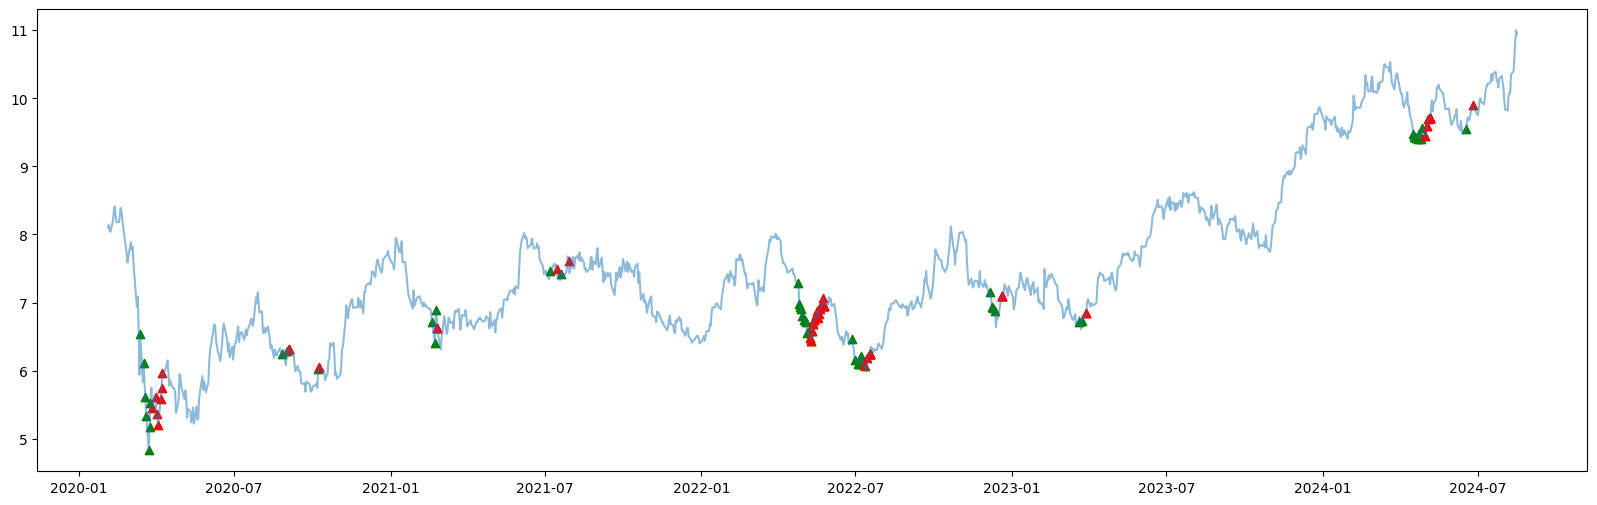

In [97]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,6))
plt.scatter(data.loc[buy_dates].index, data.loc[buy_dates]['Adj Close'], marker='^', c='g')
plt.scatter(data.loc[sell_dates].index, data.loc[sell_dates]['Adj Close'], marker='^', c='r')

plt.plot(data['Adj Close'], alpha=0.5)

# 9. Calculando Lucros

In [98]:
profit = data.loc[sell_dates]['Open'].values/data.loc[buy_dates]['Open'].values - 1 

# 10. Analisando Lucros

In [99]:
# Total Lucro
# % de operações vencedoras 
# Expectativa matemática do modelo 
# Retorno Acumulado 
# Retorno acumulado venceu o buy and hold?

In [100]:
winning_ops = (len(profit[profit > 0]/len(profit)))/100
avg_profit = np.mean(profit[profit > 0])
avg_losses = abs(np.mean(profit[profit < 0]))
math_expectation = ((winning_ops * avg_profit) - ((1 - winning_ops) * avg_losses)) * 100
acumulated_profit = (np.cumprod((1+profit))-1) * 100

print(f"Winning Ops: {winning_ops * 100}%")
print(f"Avg Profit: {avg_profit.round(2) * 100}%")
print(f"Avg Lost: {avg_losses.round(2) * 100}%")
print(f"Math Expectation: {math_expectation.round(2)}%")


Winning Ops: 40.0%
Avg Profit: 3.0%
Avg Lost: 6.0%
Math Expectation: -2.01%


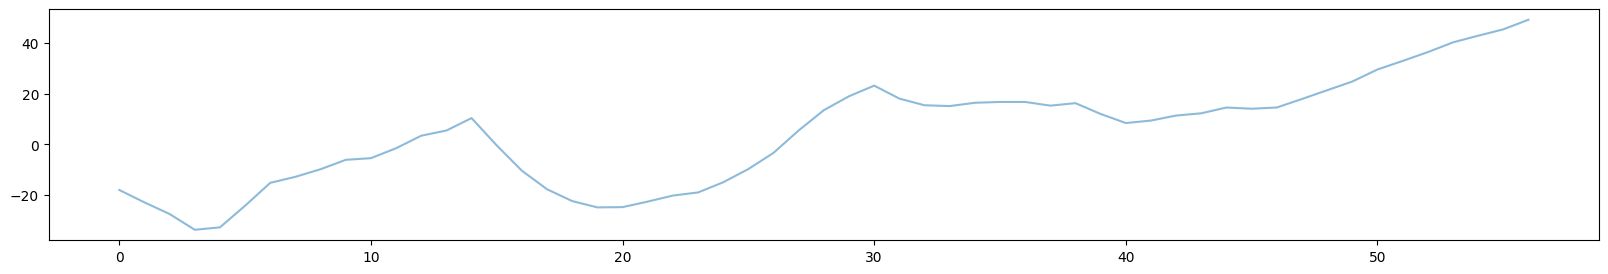

In [101]:
plt.figure(figsize=(20,3))
plt.plot(acumulated_profit, alpha=0.5)

In [102]:
buy_and_hold = data['Adj Close'].iloc[-1]/data['Adj Close'].iloc[0] - 1
print(f"Retorno Buy and Holf: {round(buy_and_hold * 100,2)}%")

Retorno Buy and Holf: 35.06%
